In [216]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
#%matplotlib notebook

from datetime import datetime as dt
from pandas_datareader import data as pdr

import tensorflow as tf

import os

## Constants

In [2]:
# Figsize
BIG = (20,10)
MEDIUM = (15, 8)
SMALL = (7,5)

#



# Load Shares

In [3]:
def load_share(ticker, start, end):
    
    share = pdr.DataReader(ticker, 'yahoo', start, end)
    
    return share

def load_shares(tickers, start, end):
    df_data = pd.DataFrame()
    df_return = pd.DataFrame()
    
    for ticker in tickers:
        df_ticker = load_share(ticker, start, end)['Adj Close']
        df_ticker.name = ticker
        
        df_return['{}_Log_Return'.format(ticker)] = np.log(df_ticker.shift(-1)) - np.log(df_ticker)
        #display(df_share)
        
        df_data = df_data.join(df_ticker, how='right')
        
    return df_data, df_return

In [4]:
def plot_series(time, series, format="-", start=0, end=None,
                figsize=BIG, c='b'):
    plt.figure(figsize=figsize)
    plt.plot(time[start:end], series[start:end], format, c=c)
    plt.xticks(rotation=60, fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.grid(True)

In [5]:
# DAL --> Delta Airlines
# UAL --> United Airlines
# AAL --> American Airlines
# LHA --> Lufthansa

tickers = ['DAL', 'UAL', 'AAL', 'LHA.DE']
start = dt(2019,1,1)

today = dt.today()
end = dt(today.year, today.month, today.day)

df_shares, df_return = load_shares(tickers, start, end)
df_shares = df_shares.rename(columns={'LHA.DE':'LHA'})
tickers = df_shares.columns

df_shares.head()

,DAL,UAL,AAL,LHA
Date,,,,
2019-01-02,48.431698,84.180000,31.963160,18.998367
2019-01-03,44.100014,80.000000,29.581665,18.503593
2019-01-04,46.207840,82.680000,31.530161,19.003172
2019-01-07,46.265854,83.230003,32.425678,19.036797
2019-01-08,45.898434,82.379997,31.904110,19.329819


# EDA

## check Nan

In [6]:
def cleaningShares(df):
    
    data = df.asfreq('d', method='ffill')
    data = data.fillna(method='ffill')
    
    return data

In [13]:
df_shares.isnull().sum()

DAL    9
UAL    9
AAL    9
LHA    0
dtype: int64

In [7]:
df_shares = cleaningShares(df_shares)

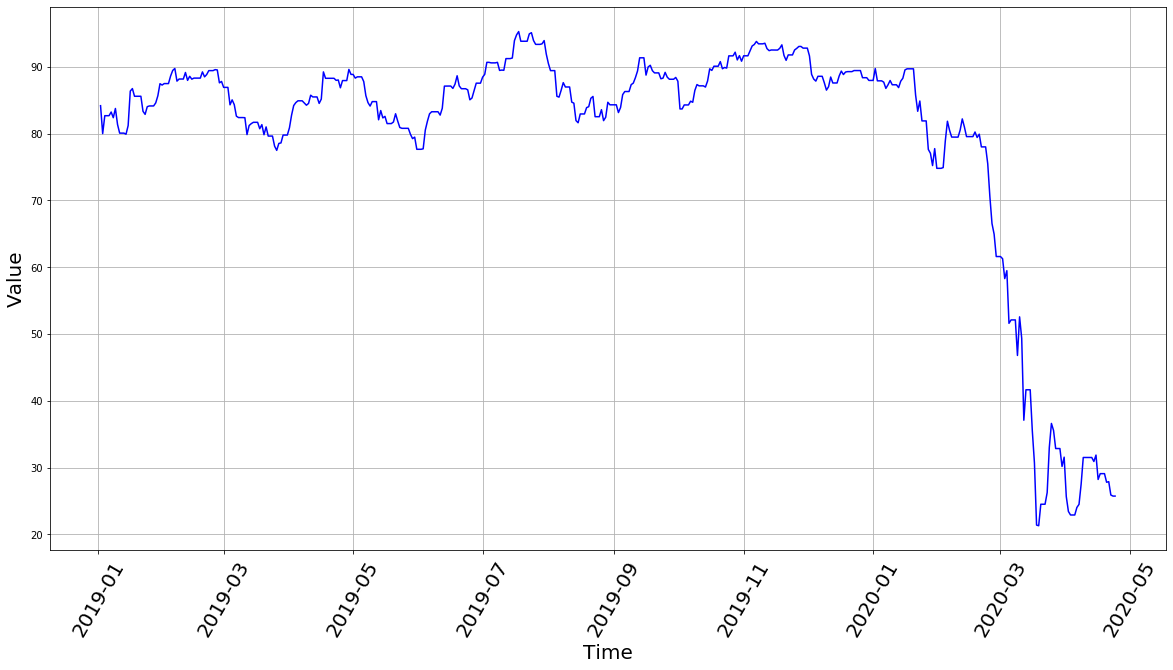

In [8]:
plot_series(df_shares.index, df_shares.UAL)

## check Decomposition 

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import norm

In [10]:
def decompose(series, start):
    
    bound_series = series[start:]
    
    dec = seasonal_decompose(bound_series.asfreq('d', method='ffill'))
    
    fig, axs = plt.subplots(4,1, figsize=BIG)
    
    axs[0].set_title(bound_series.name.upper())
    #axs[0].tick_params(rotation=60)
    axs[0].plot(dec.observed, label='data')
    axs[0].legend()
    
    axs[1].plot(dec.seasonal, label='Seasons')
    axs[1].legend()
    
    axs[2].plot(dec.trend, label='Trend')
    axs[2].axhline(np.mean(dec.trend), c='grey', label='Mean')
    axs[2].legend()
    
    axs[3].plot(dec.resid, label='Residual')
    axs[3].axhline(0, c='r', label='Zero')
    axs[3].legend()
    
    plt.show()
    
    d = check_residual(dec.resid)
    
    return dec, d
    
def check_residual(residual):
    resid = residual.dropna()
    
    sn.distplot(resid, fit=norm)
    plt.show()
    
    plot_acf(resid, lags=30)
    plt.show()
    
    d = test_durbin_watson(residual)
    
    return d

def test_durbin_watson(residual):
    
    resid = residual.dropna()
    
    x_axis = np.arange(0,10)
    
    plt.figure(figsize=(BIG[0],5))
    plt.ylim(0,4)
    
    plt.fill_between(x_axis, 2.5, 4, color='#9cefa0', label='Positive Correlation')
    plt.fill_between(x_axis, 1.5, 0, color='#ff6666', label='Negative Correlation')
    
    d = durbin_watson(resid)
    
    plt.axhline(d, c='b', linewidth=2, label='Durbin Watson Test: {:.3f}'.format(d))
    plt.legend(loc='best')
    plt.show()
    
    return d

In [11]:
start = '2019-1-1'

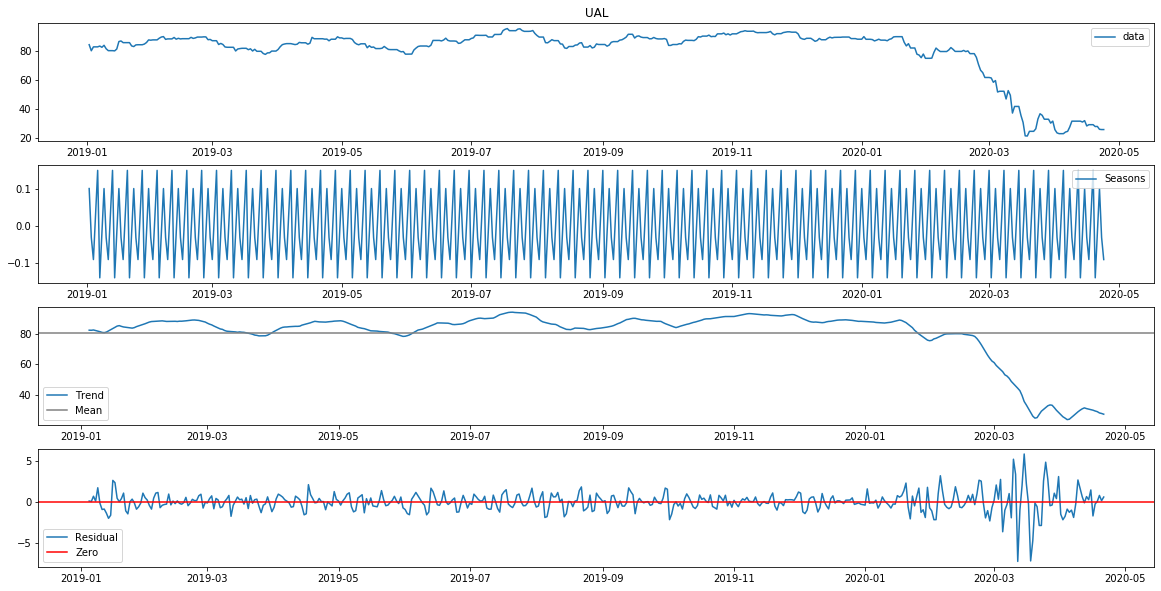

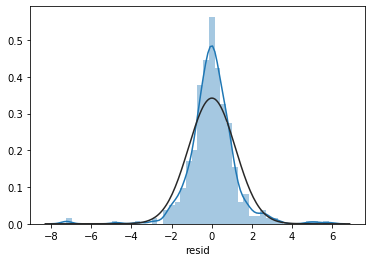

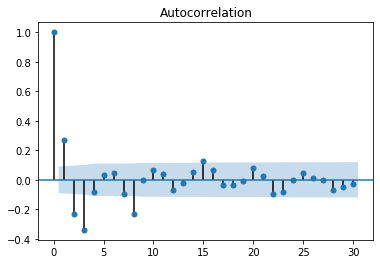

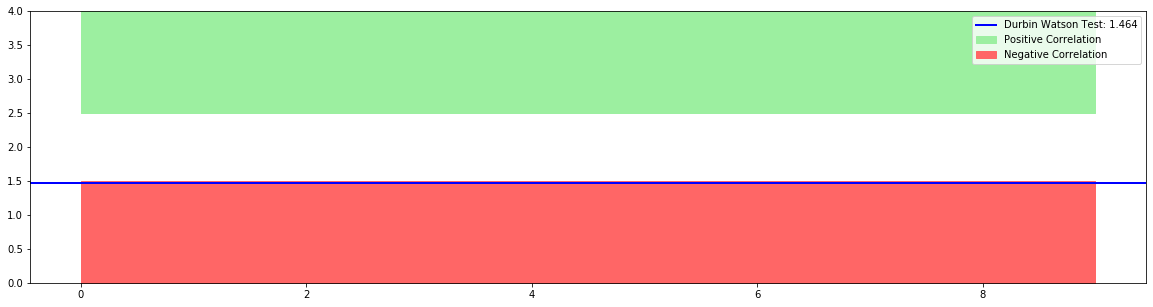

In [187]:
a = decompose(df_shares.UAL, start)

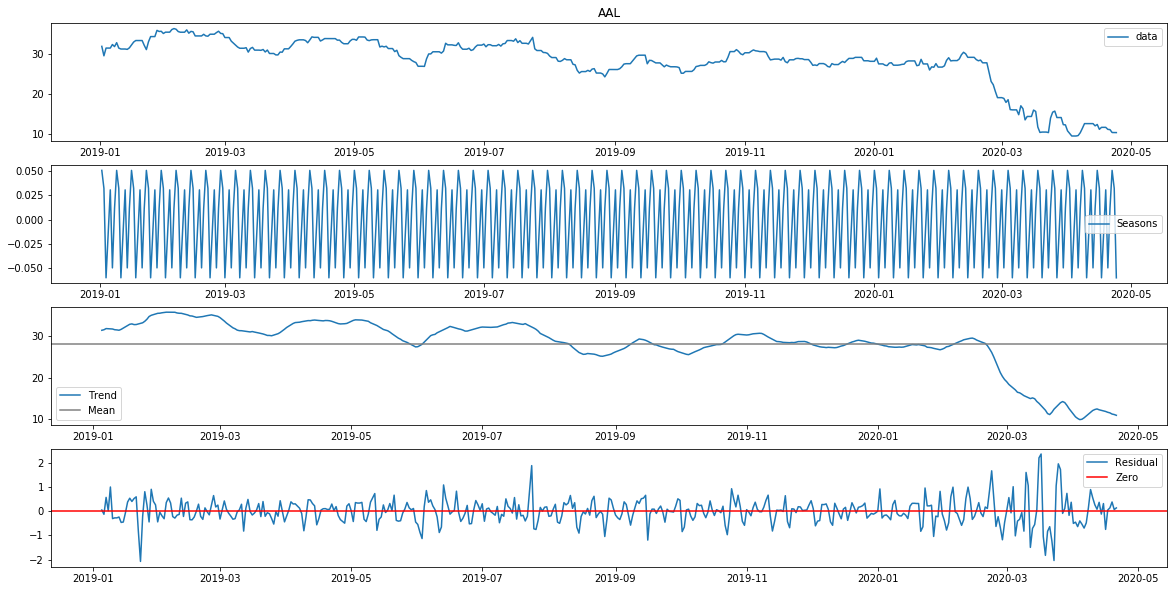

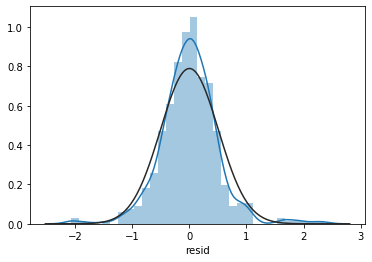

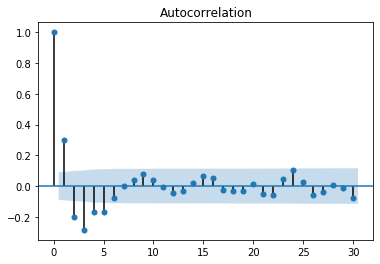

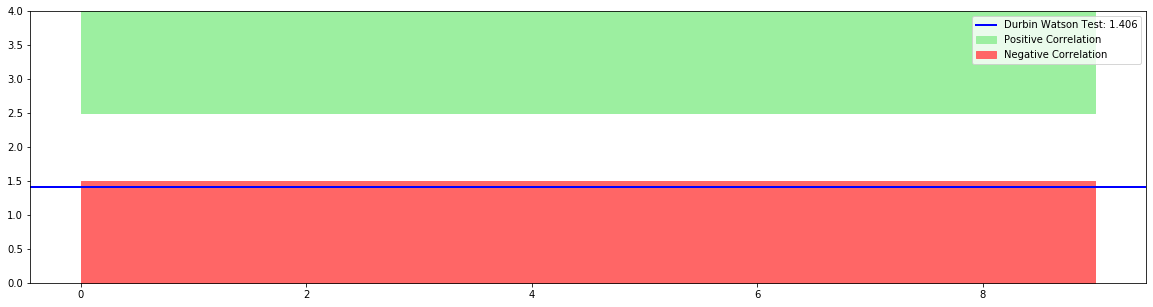

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fb422eed940>,
 1.4064455311081148)

In [188]:
decompose(df_shares.AAL, start)

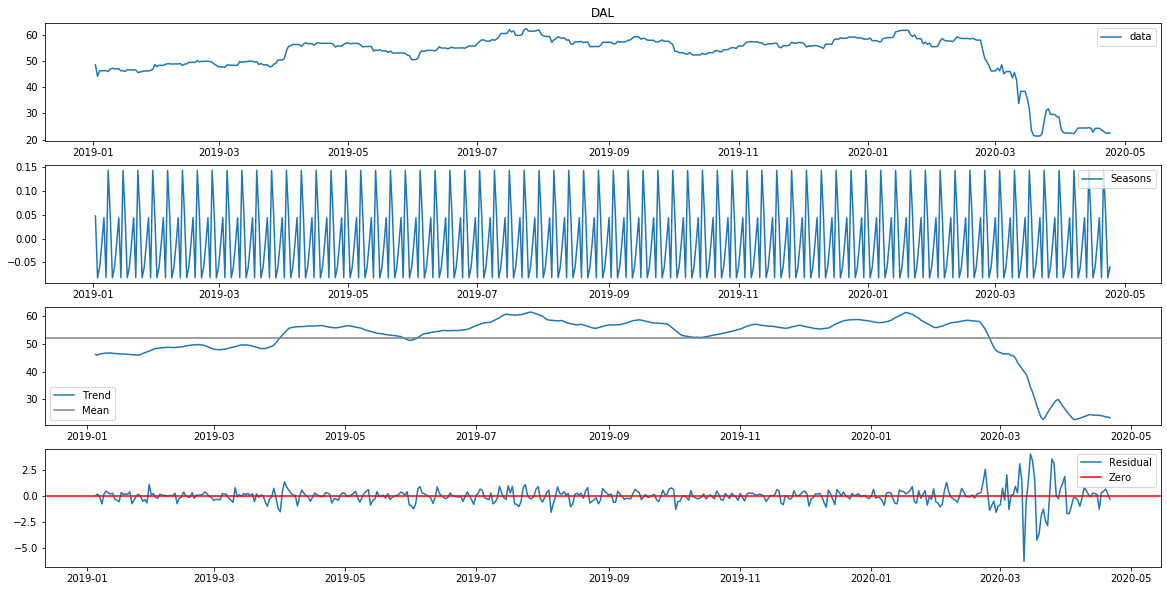

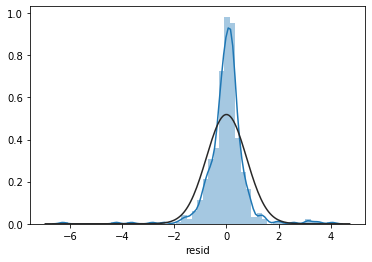

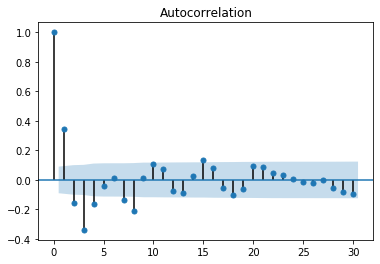

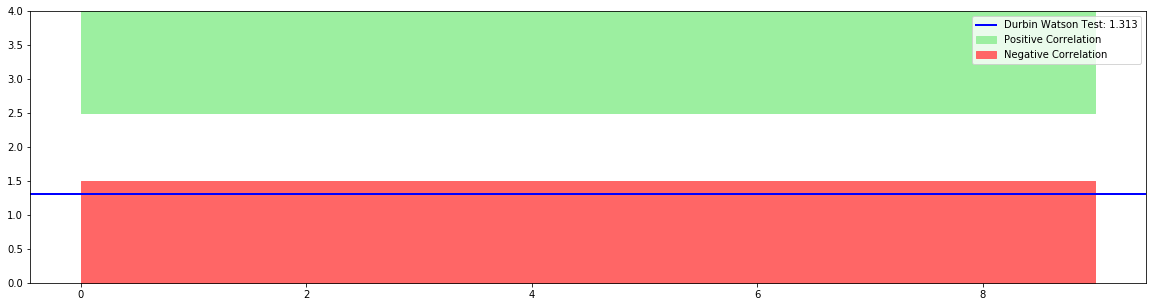

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fb4295f9860>,
 1.3128621287731033)

In [189]:
decompose(df_shares.DAL, start)

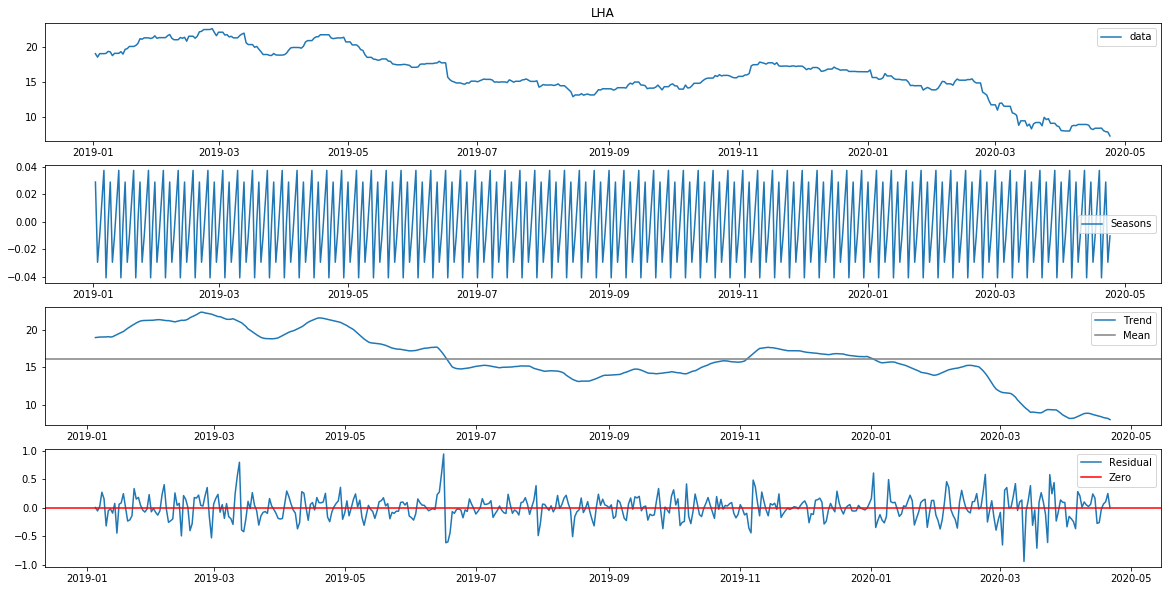

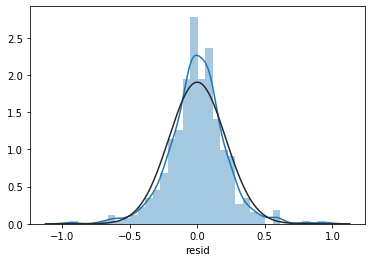

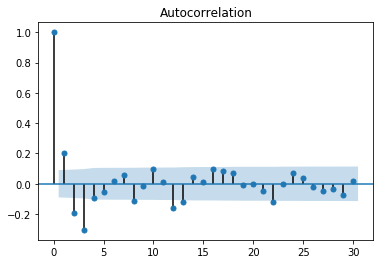

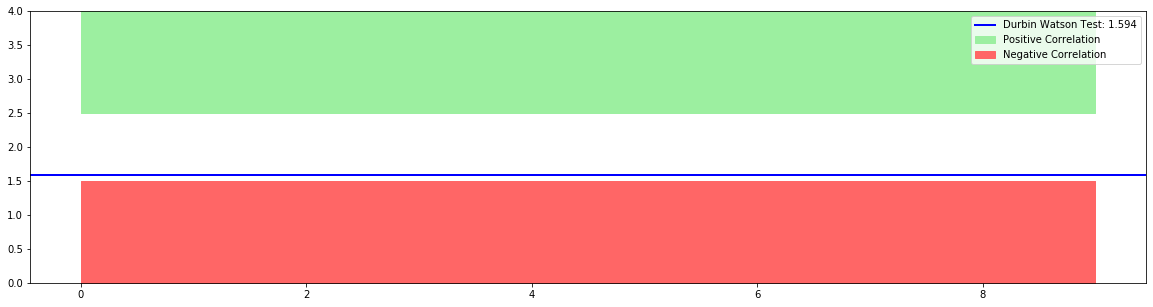

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fb42825a5f8>,
 1.5938064049039389)

In [190]:
decompose(df_shares.LHA, start)

## Check Stats

In [12]:
df_mean = df_shares.apply(lambda x:x.mean())
df_std = df_shares.apply(lambda x:x.std())
df_skew = df_shares.skew()

In [13]:
ticker = tickers[3]

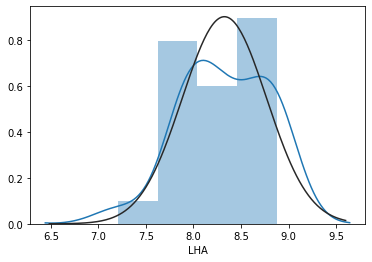

In [14]:
sn.distplot(df_shares[ticker]['2020-4-1':], fit=norm)
plt.show()

## Autocorrelation

In [15]:
def partial_autocorr(series, threshold):
    p_corr = pd.Series(pacf(series)).sort_values(ascending=False)
    
    p = p_corr[p_corr > threshold].index[-1]
    
    print('Series: {}\n'.format(series.name.upper()))
    print(p_corr[p_corr > threshold])
    
    return p

def autocorr(series, threshold, n_max):
    autocorr = pd.Series(acf(series)).sort_values(ascending=False)
    
    auto = autocorr[autocorr > threshold].index
    
    d=0
    
    if(len(auto)>n_max):
        d = 5
    
    print('Series: {}\n'.format(series.name.upper()))
    print(p_corr[p_corr > threshold])
    
    return p

In [ ]:
p_corr = pd.Series(acf(df_shares[share])).sort_values(ascending=False)
p_corr[p_corr > 0.7]

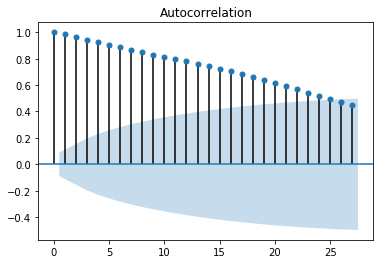

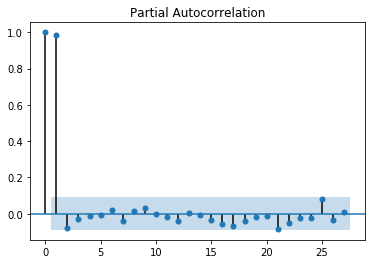

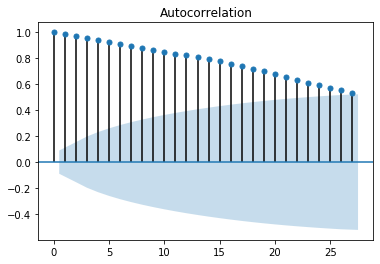

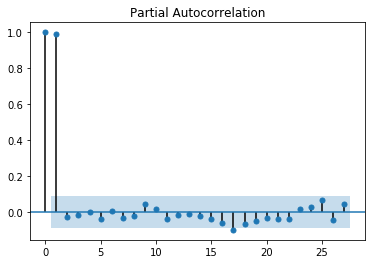

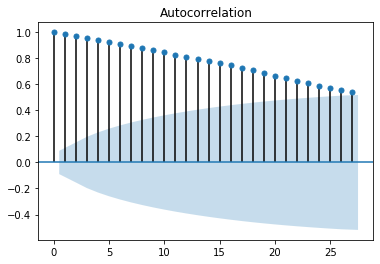

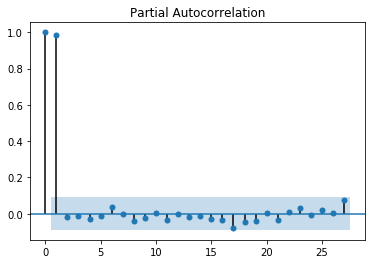

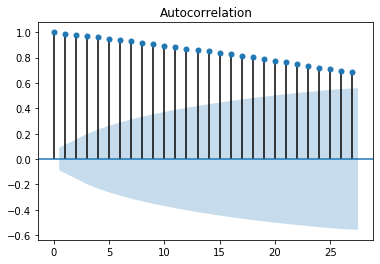

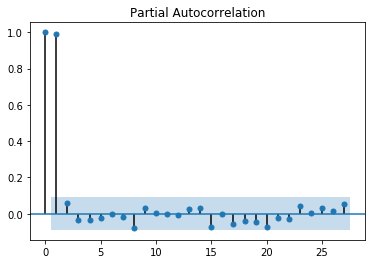

In [16]:
for share in df_shares:
    
    plot_acf(df_shares[share])
    plot_pacf(df_shares[share])
    
plt.show()

# Pre-processing

## Functions

In [17]:
def windowed_dataset(series, params):
    
    window_size = params['window_size']
    batch_size = params['batch_size']
    shuffle_buffer = params['shuffle_buffer']
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [244]:
def plot_train_valid(x_train, x_valid):
    
    plt.figure(figsize=BIG)
    plt.xticks(rotation=45, fontsize=20)
    plt.plot(x_train, c='b', label='Train')
    plt.plot(x_valid, c='r', label='Valid')
    plt.legend(loc='best', fontsize=20)
    plt.grid()
    plt.show()
    
def plot_trends(trends, labels, colors=['green', 'blue', 'red']):
    
    plt.figure(figsize=BIG)
    plt.xticks(rotation=45, fontsize=20)
    
    for i in range(len(trends)):
        plt.plot(trends[i], c=colors[i], label=labels[i])
        
    plt.legend(loc='best', fontsize=20)
    plt.grid()
    plt.show()

## Parameters

In [243]:
ticker = 'UAL'
start = '2020-1-1'
series = df_shares[ticker][start:]

window = 20
batch_size = 32
shuffle_buffer_size = 230

split = int(0.8*len(series))

params = {'ticker':ticker,
          'start':start,
          'window_size':window,
          'batch_size':batch_size,
          'shuffle_buffer':shuffle_buffer_size,
          'split':split}

## Dataset

In [245]:
x_train = series.iloc[:split]
x_valid = series.iloc[split-1:]

dataset = windowed_dataset(x_train.values, params)

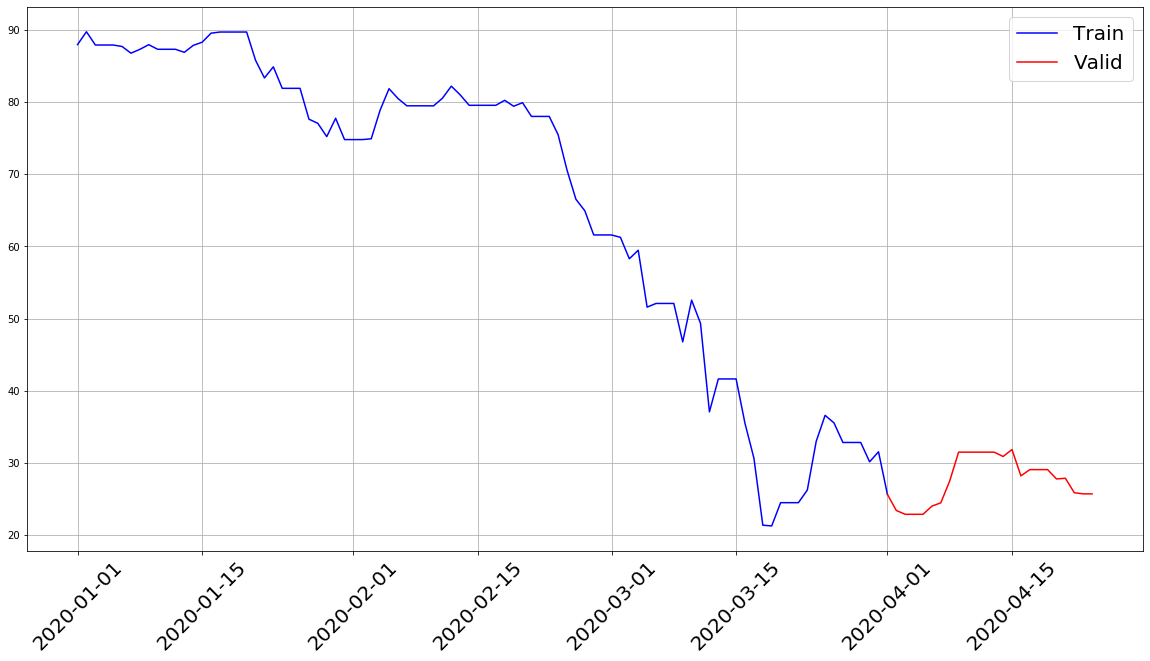

In [246]:
plot_train_valid(x_train, x_valid)

# Models

In [289]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv1D, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

tf.random.set_seed(0)
np.random.seed(0)


In [266]:
def plot_loss(history, offset=0):
    loss = history.history['loss']
    
    plt.plot(loss[offset:], c='r')
    plt.show()
    
def forecast(model, series, x_valid, params, plot=True):
    
    window_size = params['window_size']
    split = params['split']
    
    forecast = []
    time_forecast = []
    
    timestamps = series.index
    
    for i in range(len(series) - window_size):
        
        prediction = model.predict(series.values[i:i + window_size][np.newaxis])
        
        time_forecast.append(timestamps[i+window_size])
        forecast.append(prediction)

    train_forecast = forecast[:split-window_size]    
    time_train = time_forecast[:split-window_size]
    
    valid_forecast = forecast[split-window_size-1:]
    time_valid = time_forecast[split-window_size-1:]

    train_results = np.array(train_forecast)[:, 0, 0]
    train_results = pd.Series(train_results, index=time_train)
    
    valid_results = np.array(valid_forecast)[:, 0, 0]
    valid_results = pd.Series(valid_results, index=time_valid)

    #plt.figure(figsize=(10, 6))
    #plot_train_valid(train_results, valid_results)
    
    trends = [series[window_size:], train_results, valid_results]
    labels = ['Real Trend', 'Train', 'Valid']
    colors = ['green', 'blue', 'red']

    plot_trends(trends, labels)
    
    return train_results, valid_results

def evaluate_model(series, prediction, params, train=False):
    window_size = params['window_size']
    
    if(train):
        true_series = series[window_size:]
    else:
        true_series = series
    
    return tf.keras.metrics.mean_absolute_error(true_series, prediction).numpy()

def save_model(params, filename, save=True):
    
    df = pd.DataFrame(params)
    
    if(save):
        filepath = './Results/' + params['model'] + '/'
        if(os.path.exists(filepath) == False):
            os.mkdir(filepath)
            
        full_path = filepath + filename
        i = 0
        while(os.path.exists(full_path)):
            full_path = full_path.split('.csv')[0] + str(i) +'.csv'
            i += 1
            
        df.to_csv(full_path)
    
    return df

## Linear Model

In [242]:
def LinearModel(dataset, params):
    
    neurons = params['neurons']
    window_size = params['window_size']
    loss = params['loss']
    opt = params['opt']
    epochs = params['epochs']
    verbose = params['verbose']
    
    assert len(neurons) >= 2, 'Too few layers'
    
    # Model Architecture
    lin_model = Sequential()
    
    for i in range(len(neurons)):
        
        if(i==0):
            lin_model.add(Dense(neurons[i], input_shape=[window_size], activation='relu'))
        
        else:
            lin_model.add(Dense(neurons[i], activation='relu'))
            
    # Model Fitting
    lin_model.compile(loss=loss, optimizer=opt(lr=1e-6))
    hist = lin_model.fit(dataset, epochs=epochs, verbose=verbose)
    
    return lin_model, hist

### Params

In [285]:
params['model'] = 'Linear'
params['neurons'] = [30,20,1]
params['opt'] = Adam
#params['lr'] = 1e-3
params['lr'] = lr
params['epochs'] = 500
params['loss'] = 'mse'
params['verbose'] = 0

### Model

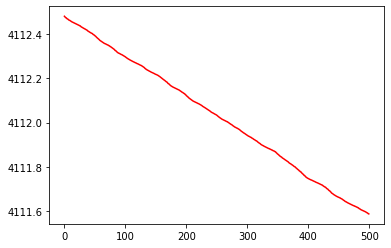

In [293]:
lin_model, hist = LinearModel(dataset, params)
plot_loss(hist)

In [169]:
#lin_model.summary()

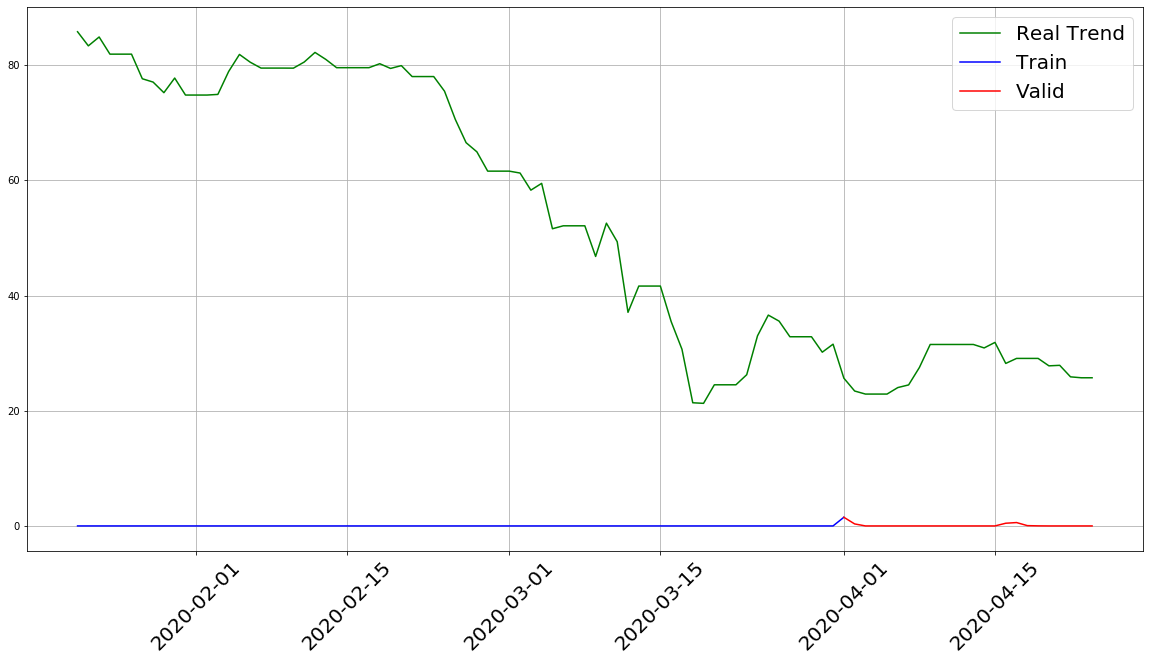

In [294]:
pred_train, pred_valid = forecast(lin_model, series, x_valid, params)

### Evaluation

In [295]:
train_error = evaluate_model(x_train, pred_train, params, train=True)
valid_error = evaluate_model(x_valid, pred_valid, params)

params['train_error'] = train_error
params['valid_error'] = valid_error

print('Train Error: {:.4f}'.format(train_error))
print('Valid Error: {:.4f}'.format(valid_error))

Train Error: 60.5455
Valid Error: 27.4786


### Saving 

In [254]:
filename = 'Adam_0'
save_model(params, filename+'.csv')

,ticker,start,window_size,batch_size,shuffle_buffer,split,model,neurons,opt,lr,epochs,loss,verbose,train_error,valid_error
0,UAL,2020-1-1,20,32,230,92,Linear,30,<class 'tensorflow.python.keras.optimizer_v2.a...,0.001,500,mse,0,7.320833,4.065588
1,UAL,2020-1-1,20,32,230,92,Linear,20,<class 'tensorflow.python.keras.optimizer_v2.a...,0.001,500,mse,0,7.320833,4.065588
2,UAL,2020-1-1,20,32,230,92,Linear,1,<class 'tensorflow.python.keras.optimizer_v2.a...,0.001,500,mse,0,7.320833,4.065588


### Hyperoptimization

In [258]:
lr = Real(1e-5, 1e-2, name='lr')

dimensions = [lr]

default_parameters = [1e-3]

In [262]:
@use_named_args(dimensions=dimensions)
def fit_linear_model(lr):
    
    neurons = params['neurons']
    window_size = params['window_size']
    loss = params['loss']
    opt = params['opt']
    epochs = params['epochs']
    verbose = params['verbose']
    
    
    
    assert len(neurons) >= 2, 'Too few layers'
    
    # Model Architecture
    lin_model = Sequential()
    
    for i in range(len(neurons)):
        
        if(i==0):
            lin_model.add(Dense(neurons[i], input_shape=[window_size], activation='relu'))
        
        else:
            lin_model.add(Dense(neurons[i], activation='relu'))
            
    # Model Fitting
    lin_model.compile(loss=loss, optimizer=opt(lr=lr))
    hist = lin_model.fit(dataset, epochs=epochs, verbose=verbose)
    
    pred_train, pred_valid = forecast(lin_model, series, x_valid, params)
    
    train_error = evaluate_model(x_train, pred_train, params, train=True)
    valid_error = evaluate_model(x_valid, pred_valid, params)
    
    return valid_error

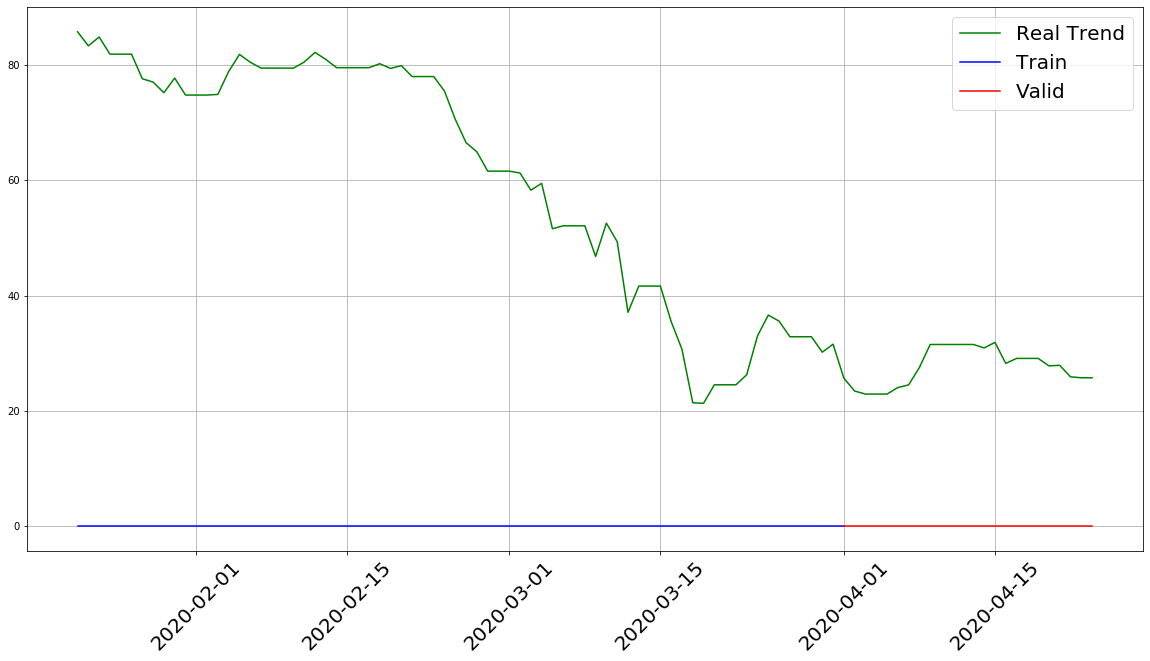

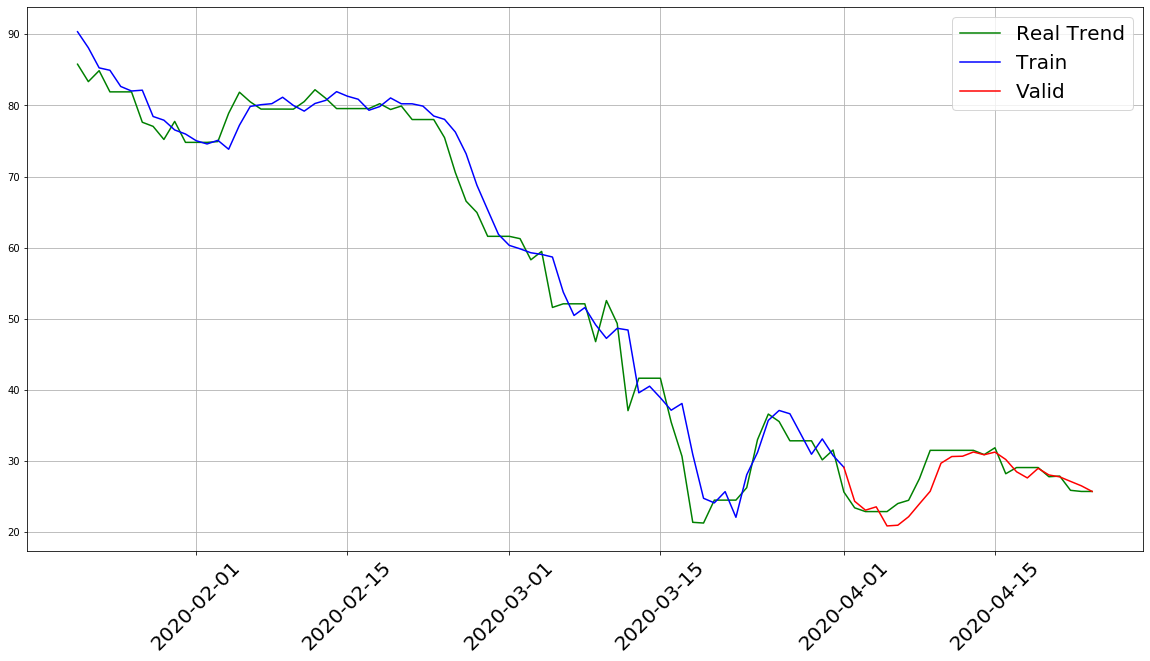

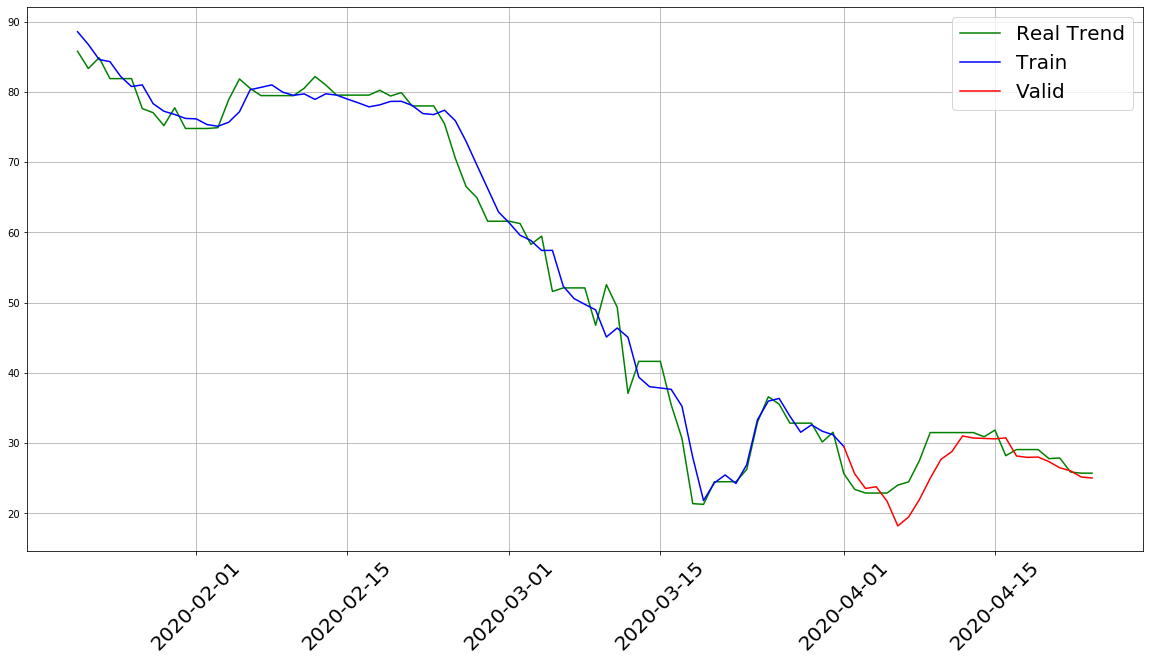

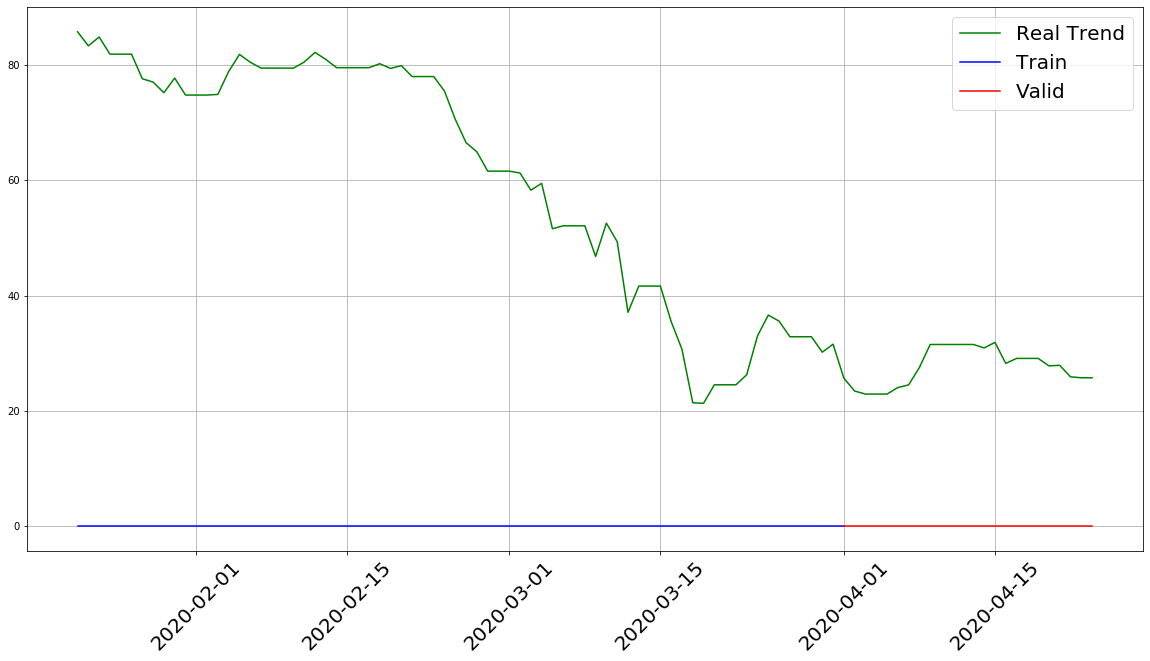

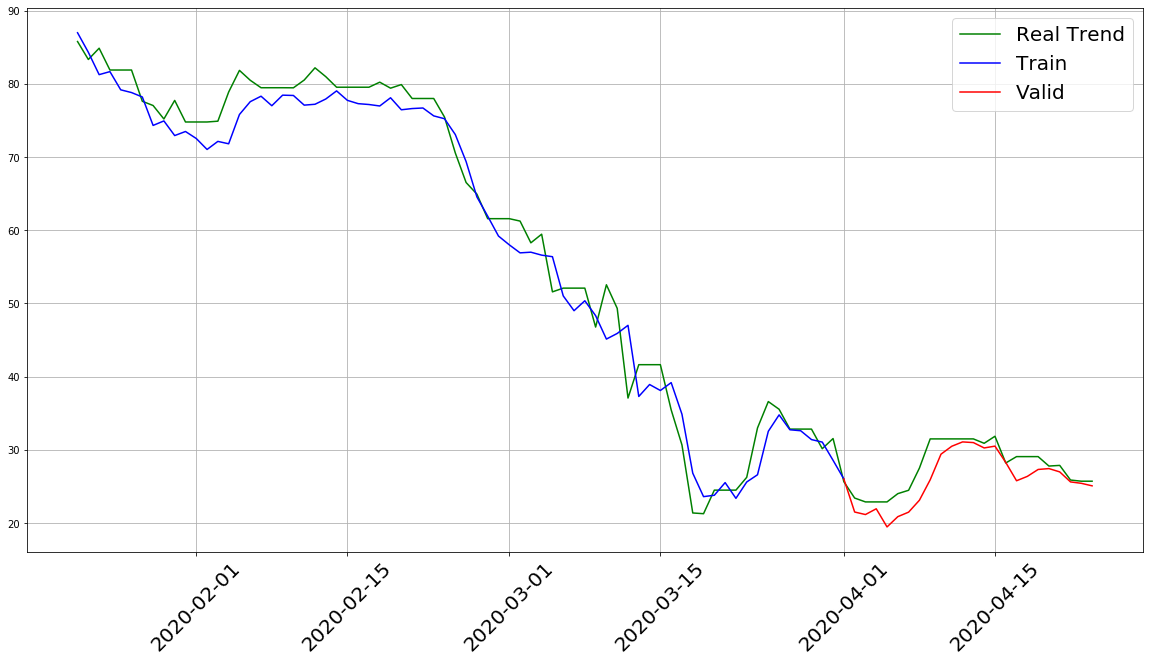

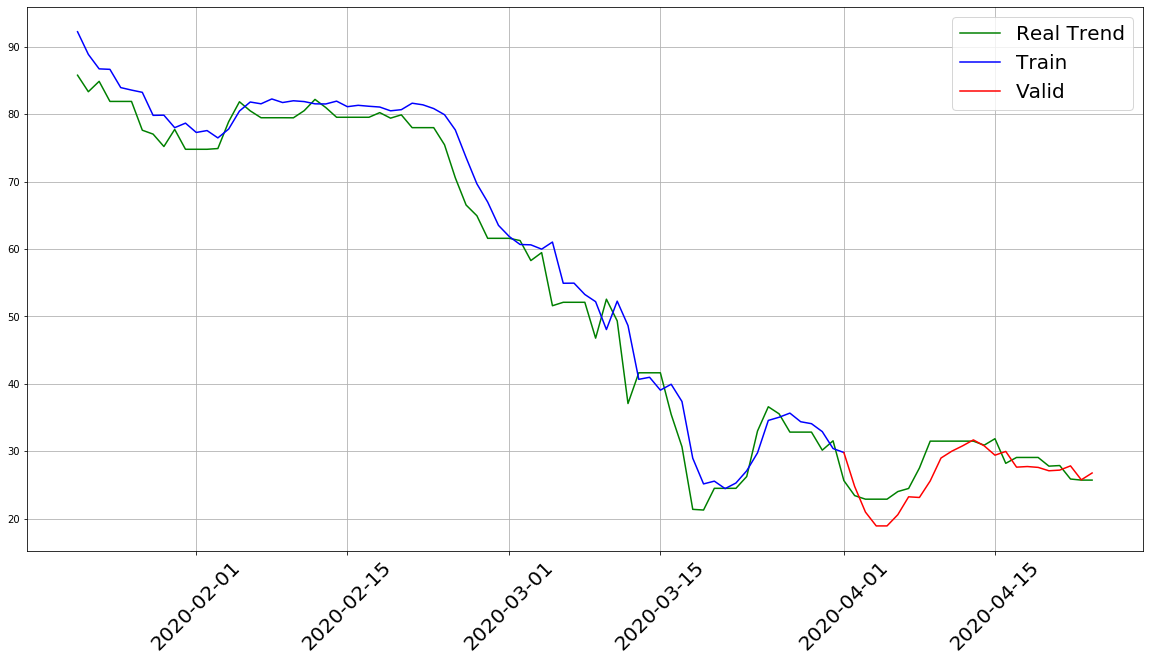

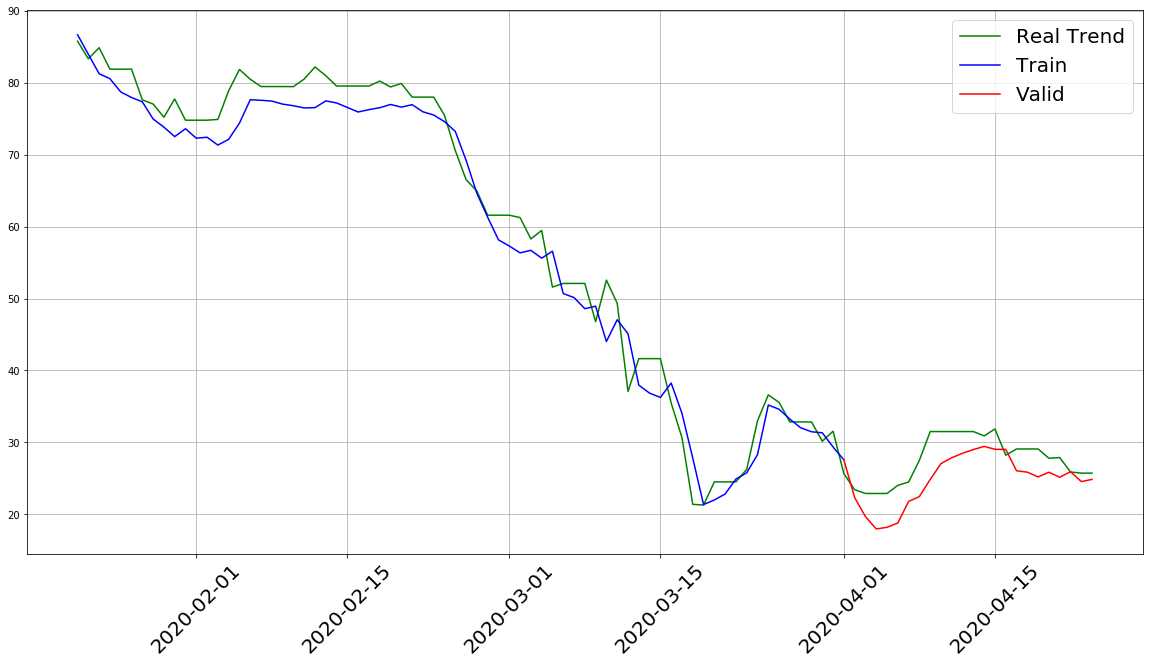

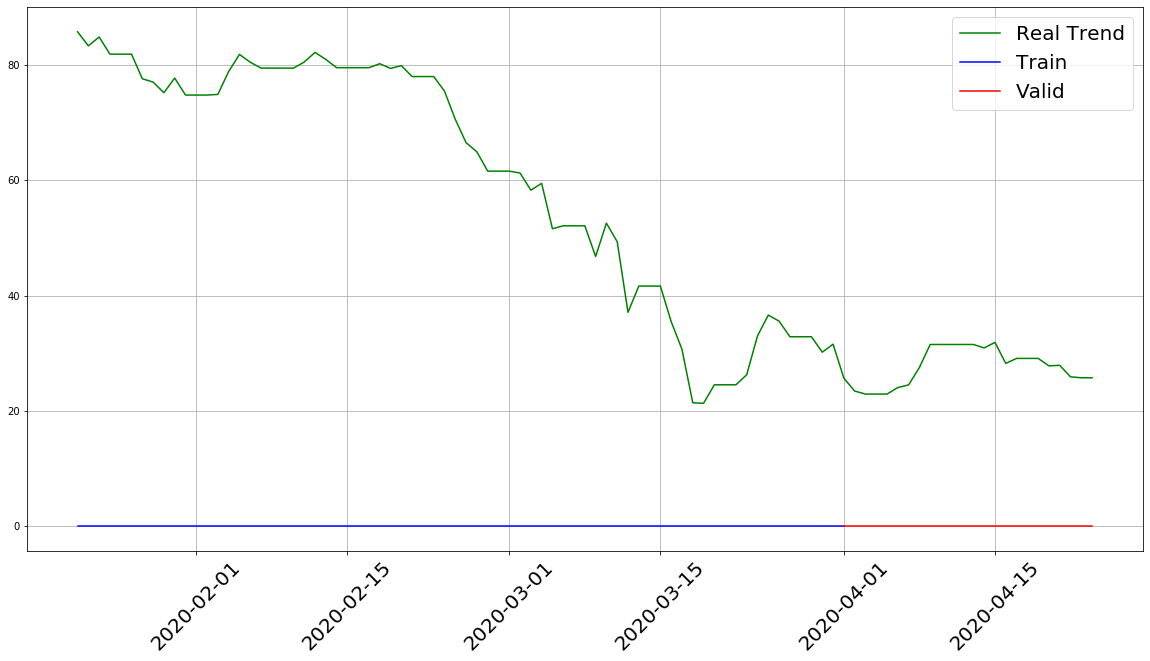

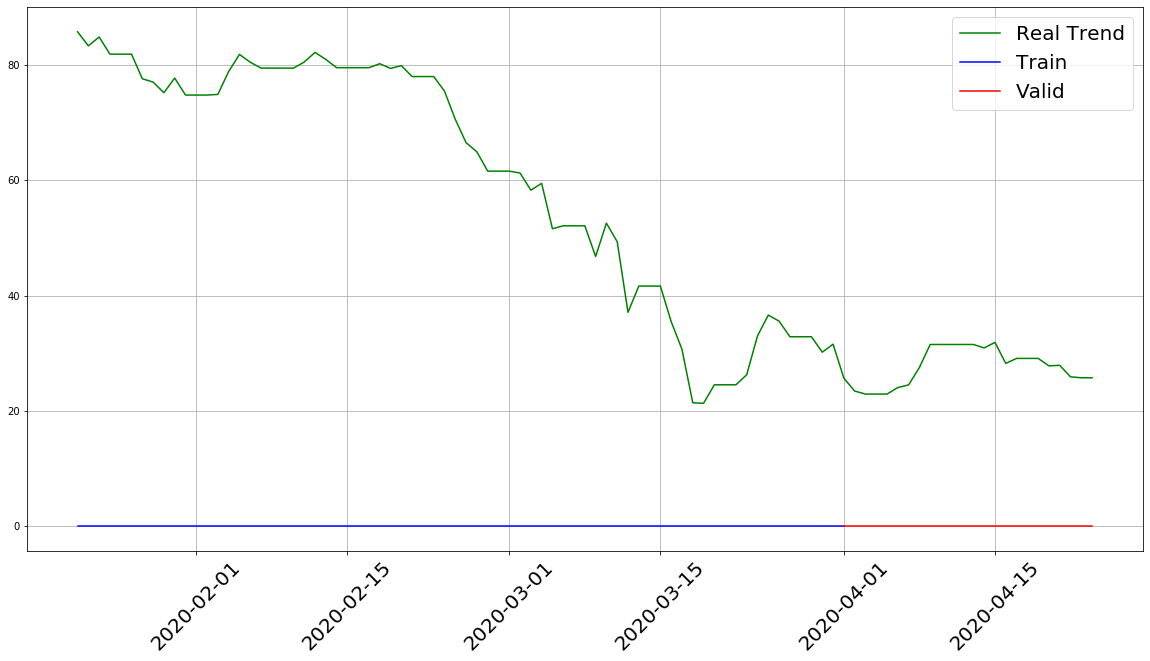

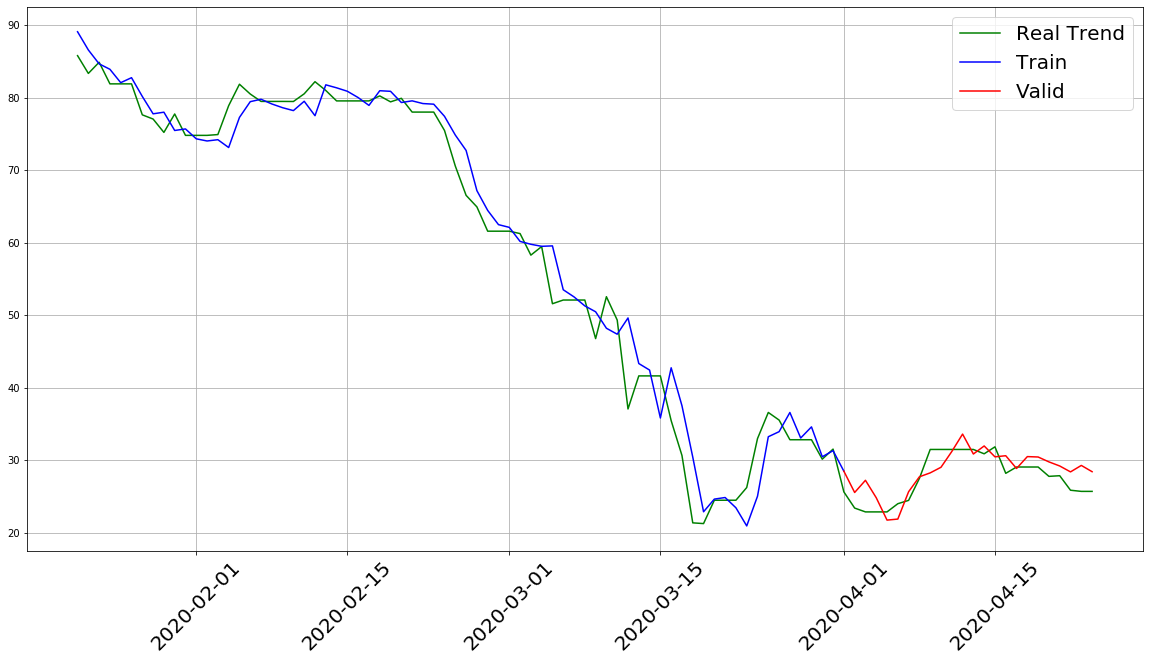

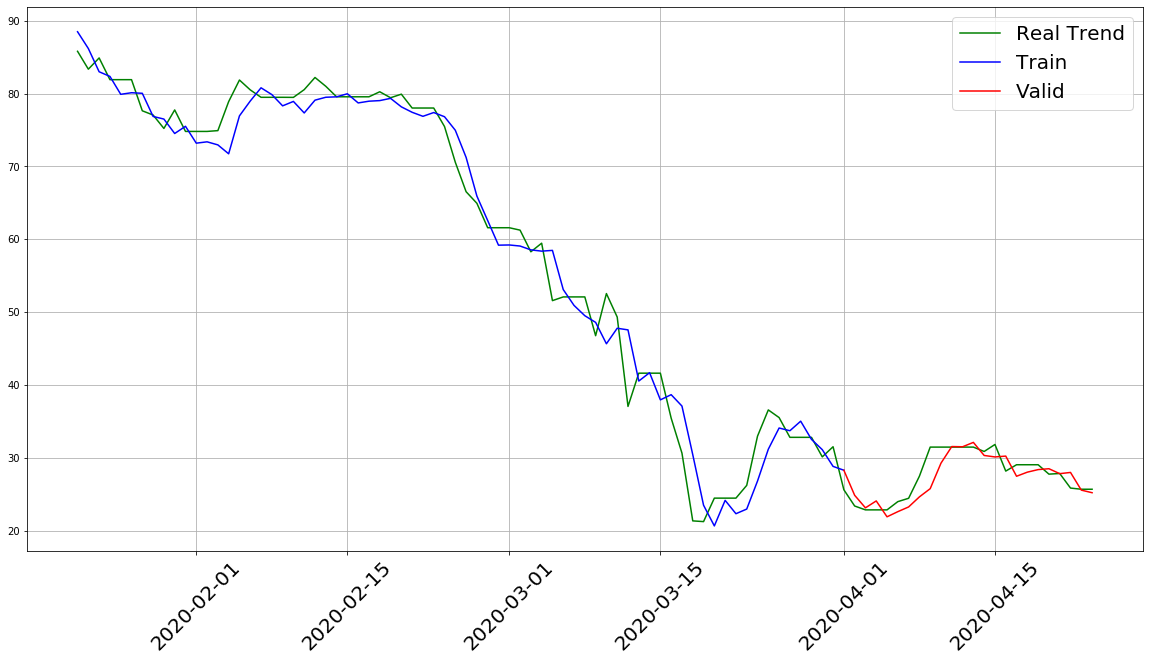

In [265]:
search_result = gp_minimize(func=fit_linear_model,

                            dimensions=dimensions,

                            acq_func='EI',  # Expected Improvement.

                            n_calls=11,

                            x0=default_parameters,

                            random_state=46)

lr = search_result.x

In [267]:
search_result

          fun: 1.323208
    func_vals: array([27.602081 ,  1.3697964,  2.0743854, 27.602081 ,  1.6956358,
        2.006668 ,  2.9639652, 27.602081 , 27.602081 ,  1.8645592,
        1.323208 ], dtype=float32)
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=1219050685)]
 random_state: RandomState(MT19937) at 0x7FD7E4162A98
        space: Space([Real(low=1e-05, high=0.01, prior='uniform', transform='normalize')])
        specs: {'args': {'func': <function fit_linear_model at 0x7fd721ca78c8>, 'dimensions': Space([Real(low=1e-05, high=0.01, prior='uniform', transform='normalize')]), 'base_estimator': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * M

In [270]:
lr = search_result.x

In [276]:
lr

[0.0023021901536305553]